In [1]:
# IMPORTING LIBRAIRIES
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from configparser import ConfigParser
import os
from scipy.ndimage import rotate

from astropy.io import fits

from psfao21.psfao21 import psfao21
from psfFitting.psfFitting import psfFitting
import fourier.FourierUtils as FourierUtils

mpl.rcParams['font.size'] = 22
usetex = True
plt.rcParams.update({
    "text.usetex": usetex,
    "font.family": "serif",
    "font.serif": ["Palatino"],
}) 

213.40642438924712

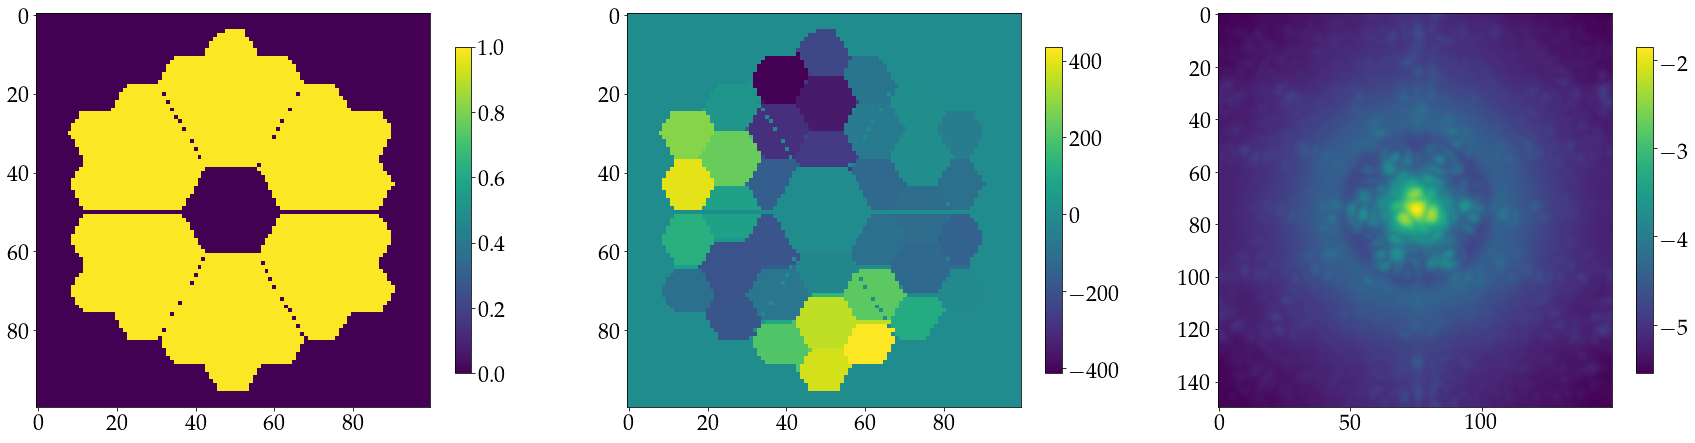

In [2]:
#instantiating the psfao21 model
path_ini = '/home/omartin/Projects/nirc2_psffitting.ini'
#parser = ConfigParser()
#parser.optionxform = str
#parser.read(path_ini)
psfao = psfao21(path_ini)

#r0^(-5/3) m^(-5/3), bg (rad^2m^2), sig2 (rad^2), ax (m^-1), p, theta (rad), beta, jx (mas), jy (mas), thetaj (rad), Flux (ADU), dy (pixel), dx (pixel), bck_im(ADU), astat (nm)
x0    = [0.5**(-5/3),1e-4,1,1e-8,1,0,1.8,0,0,0]+ [1,0,0,0] + list(np.random.randn(35)*50)
psf   = psfao(x0)


# display
opdMap= (psfao.phaseMap*psfao.wvlRef*1e9/2/np.pi)
fig , axs = plt.subplots(1,3,figsize=(30,30))
pcm = axs[0].imshow(psfao.tel.pupil)
fig.colorbar(pcm,ax=axs[0],shrink=0.2)
pcm = axs[1].imshow(opdMap)
fig.colorbar(pcm,ax=axs[1],shrink=0.2)
pcm = axs[2].imshow(np.log10(psf))
fig.colorbar(pcm,ax=axs[2],shrink=0.2)

np.std(opdMap[psfao.tel.pupil!=0])

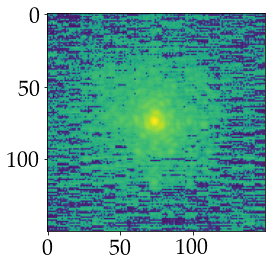

In [3]:
# Getting on-ksy PSF
path_data = '/run/media/omartin/OlivierMartinHDD/DATA/APPLY/PSF_LIBRARY/KECK_SCAO/'
file_name = '20130203_n0001.fits'
path_file = path_data + file_name
im = fits.getdata(path_file)
hdr = fits.getheader(path_file)

plt.imshow(np.arcsinh(im))

In [4]:
# DATA FITTING
# init guess
#r0^(-5/3) m^(-5/3), bg (rad^2m^2), sig2 (rad^2), ax (m^-1), p, theta (rad), beta, jx (mas), jy (mas), thetaj (rad), Flux (ADU), dy (pixel), dx (pixel), bck_im(ADU), astat (nm)
x0    = [0.5**(-5/3),1e-2,2,1e-2,1,0,1.8,0,0,0]+ [im.sum(),0,0,0] + list(np.zeros(35))
fixed = (False,)*7 + (True,)*3 + (False,)*(39)

# weights
im_n    = im#/im.sum()
ron     = 160 # in ADU
weights = np.zeros_like(im_n)
weights[im_n>0] = im_n[im_n>0]
weights = 1.0/(weights + ron**2)

#weights = np.ones_like(im)
#weights[im<0] = 0

# fitting
res   = psfFitting(im_n,psfao,x0,fixed=fixed,method='trf',verbose=2,weights=weights)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.4035e+06                                    5.24e+07    
       1              2         7.1192e+05      6.92e+05       1.50e+00       6.18e+06    
       2              3         5.3774e+05      1.74e+05       3.40e+03       2.44e+07    
       3              4         1.4751e+05      3.90e+05       3.55e+03       1.31e+07    
       4              5         7.7328e+04      7.02e+04       7.09e+03       5.54e+06    
       5              6         4.6913e+04      3.04e+04       7.09e+03       5.78e+05    
       6              7         4.3659e+04      3.25e+03       1.42e+04       4.22e+05    
       7             15         4.2121e+04      1.54e+03       2.49e+01       9.76e+04    
       8             16         4.1830e+04      2.91e+02       2.46e+01       1.73e+05    
       9             17         4.1635e+04      1.95e+02       2.48e+01       1.07e+05    

<ipython-input-9-526bb2b20a61>:31: RuntimeWarning: invalid value encountered in log10
  plt.plot(x,np.log10(prof_sky),'b',label='On-ksy')
<ipython-input-9-526bb2b20a61>:32: RuntimeWarning: invalid value encountered in log10
  plt.plot(x,np.log10(FourierUtils.radial_profile(res.im_fit,nargout=1)),'r',label='Fitting')
<ipython-input-9-526bb2b20a61>:33: RuntimeWarning: invalid value encountered in log10
  plt.plot(x,np.log10(FourierUtils.radial_profile((res.im_fit - res.im_sky),nargout=1)),'k:',label='Residual')


Text(0, 0.5, 'Azimuthal profile [arcsinh scale]')

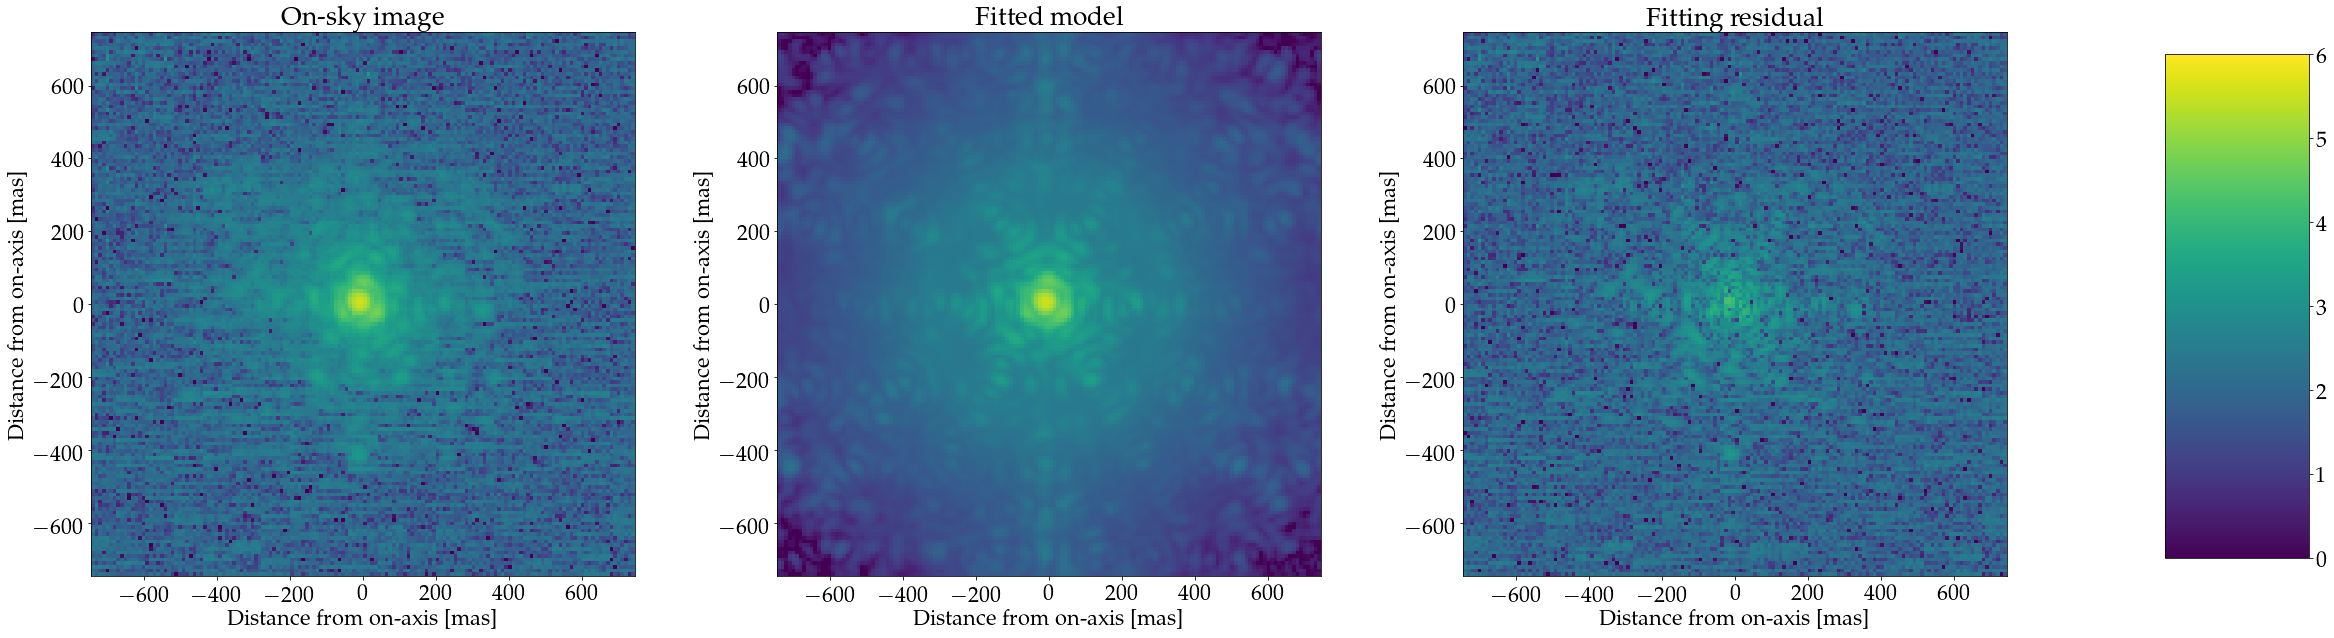

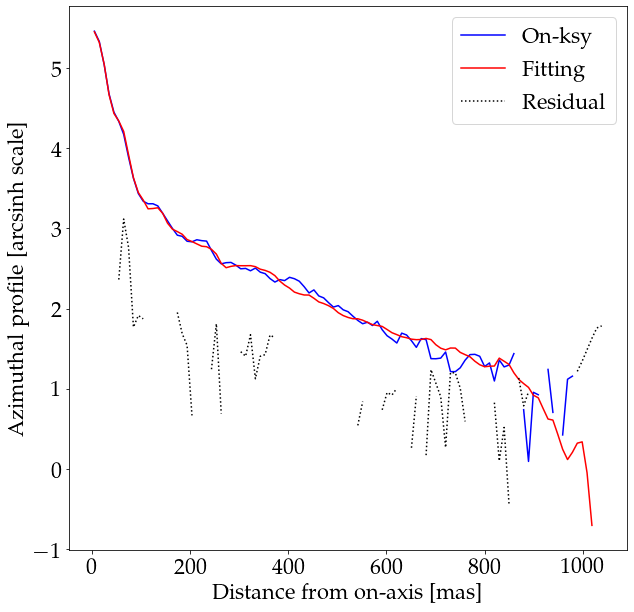

In [9]:
psInMas = 9.94
fov  = 150*psInMas
vmin = 0#np.log10(res.im_sky).min()
vmax = 6#np.log10(res.im_sky).max()

plt.close('all')
fig, axs = plt.subplots(1,3,figsize=(40,10))
axs[0].imshow(np.log10(abs(res.im_sky)),vmin=vmin,vmax=vmax,extent=[-fov/2,fov/2,-fov/2,fov/2])
axs[0].set_xlabel('Distance from on-axis [mas]')
axs[0].set_ylabel('Distance from on-axis [mas]')
axs[0].set_title('On-sky image')

axs[1].imshow(np.log10(abs(res.im_fit)),vmin=vmin,vmax=vmax,extent=[-fov/2,fov/2,-fov/2,fov/2])
axs[1].set_xlabel('Distance from on-axis [mas]')
axs[1].set_ylabel('Distance from on-axis [mas]')
axs[1].set_title('Fitted model')

pcm=axs[2].imshow(np.log10(abs(res.im_fit - res.im_sky)),vmin=vmin,vmax=vmax,extent=[-fov/2,fov/2,-fov/2,fov/2])
axs[2].set_xlabel('Distance from on-axis [mas]')
axs[2].set_ylabel('Distance from on-axis [mas]')
axs[2].set_title('Fitting residual')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(pcm, cax=cbar_ax)


x , prof_sky = FourierUtils.radial_profile(res.im_sky)
x = x*psInMas
plt.figure(figsize=(10,10))
plt.plot(x,np.log10(prof_sky),'b',label='On-ksy')
plt.plot(x,np.log10(FourierUtils.radial_profile(res.im_fit,nargout=1)),'r',label='Fitting')
plt.plot(x,np.log10(FourierUtils.radial_profile((res.im_fit - res.im_sky),nargout=1)),'k:',label='Residual')
plt.legend()
plt.xlabel('Distance from on-axis [mas]')
plt.ylabel('Azimuthal profile [arcsinh scale]')

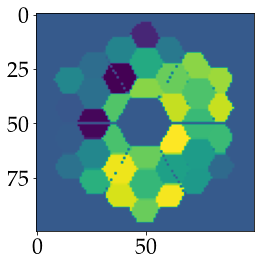

In [10]:
plt.imshow(psfao.phaseMap*psfao.wvlRef*1e9/2/np.pi)

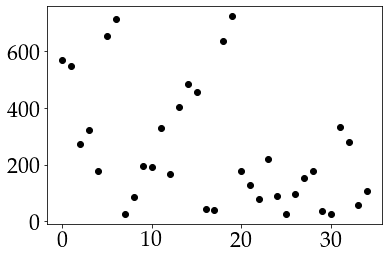

In [12]:
plt.plot(abs(res.x[-35:]),'ko')

In [15]:
res.x[0:6]

array([1.14814501, 0.02740565, 0.51714643, 0.0791764 , 1.09405258,
       2.9492387 ])

In [20]:
res.FWHMx_fit

40.99519397283208

In [23]:
res

   FWHMx_fit: 40.99519397283208
   FWHMx_sky: 40.44113371199094
   FWHMy_fit: 37.68937953969799
   FWHMy_sky: 35.57484820951763
      SR_fit: 0.56787
      SR_sky: 0.62991
 active_mask: array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])
        cost: 37223.89309123496
         fun: array([-0.05857718,  0.11328609, -0.46057575, ..., -0.99753812,
        0.00741086,  0.1510735 ])
         fvu: 0.3365028536499104
        grad: array([ 4.52675893e-04,  9.49652658e-02, -4.35564364e-01, -1.96644063e+01,
       -2.60000106e+00,  2.48140326e-01, -1.37412368e+02, -2.67487631e-08,
       -4.64954830e-01,  5.38110870e-02, -1.03320508e-05,  1.88366296e-03,
       -3.28247806e-03,  1.64082460e-02, -2.21183353e-02,  9.17800414e-03,
       -5.07357453e-03,  1.12823464e-02, -9.71465419e-03, -3.10769942e-03,
        4.17303647e-03,  7.41993567e-03, -1.27646043e-02, -2.68724376e-02,
       -3.678